In [1]:
import networkx as nx
import itertools
import pandas as pd
import numpy as np
from stellargraph import StellarGraph
from rdkit.Chem import AllChem, DataStructs
import json
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow import keras

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_regression, link_classification
from tensorflow.keras import Model, optimizers, losses, metrics

import multiprocessing
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt

2023-06-14 16:52:30.937748: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-14 16:52:41.288051: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
g = nx.read_graphml("./graph/lotus_DB_as_graph.gml")
species_features_dummy = pd.read_csv("./data/species_features_dummy.csv", index_col=0)
molecule_features_dummy = pd.read_csv("./data/molecule_features_dummy.csv", index_col=0)
df_agg = pd.read_csv("./data/lotus_aggregated.csv", index_col=0)

In [3]:
G = StellarGraph.from_networkx(g,
                               node_features={'species':species_features_dummy,
                                              'molecule': molecule_features_dummy})
print(G.info())
G.check_graph_for_ml()

StellarDiGraph: Directed multigraph
 Nodes: 23250, Edges: 49154

 Node types:
  molecule: [12893]
    Features: float32 vector, length 625
    Edge types: molecule-present_in->species, molecule-similar_to->molecule
  species: [10357]
    Features: float32 vector, length 5024
    Edge types: species-has->molecule

 Edge types:
    species-has->molecule: [20000]
        Weights: range=[1, 180], mean=1.90475, std=2.49307
        Features: none
    molecule-present_in->species: [20000]
        Weights: range=[1, 180], mean=1.90475, std=2.49307
        Features: none
    molecule-similar_to->molecule: [9154]
        Weights: range=[0.8, 1], mean=0.897606, std=0.0758458
        Features: none


In [4]:
batch_size = 200 #default: 200
epochs = 20
# Use 80% of edges for training, the rest for testing:
train_size = 0.8
test_size = 0.2
num_samples = [8, 4]
num_workers = multiprocessing.cpu_count()-2

In [5]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=False, edge_label="present_in"
)

Network has 20000 edges of type present_in
Network has 20000 edges of type present_in
** Sampled 2000 positive and 2000 negative edges. **


In [6]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=False, edge_label="present_in"
)

Network has 18000 edges of type present_in
Network has 18000 edges of type present_in
** Sampled 1800 positive and 1800 negative edges. **


In [7]:
print(G_train.info())

StellarDiGraph: Directed multigraph
 Nodes: 23250, Edges: 45354

 Node types:
  molecule: [12893]
    Features: float32 vector, length 625
    Edge types: molecule-present_in->species, molecule-similar_to->molecule
  species: [10357]
    Features: float32 vector, length 5024
    Edge types: species-has->molecule

 Edge types:
    species-has->molecule: [20000]
        Weights: range=[1, 180], mean=1.90475, std=2.49307
        Features: none
    molecule-present_in->species: [16200]
        Weights: range=[1, 180], mean=1.9113, std=2.63048
        Features: none
    molecule-similar_to->molecule: [9154]
        Weights: range=[0.8, 1], mean=0.897606, std=0.0758458
        Features: none


In [8]:
print(G_test.info())

StellarDiGraph: Directed multigraph
 Nodes: 23250, Edges: 47154

 Node types:
  molecule: [12893]
    Features: float32 vector, length 625
    Edge types: molecule-present_in->species, molecule-similar_to->molecule
  species: [10357]
    Features: float32 vector, length 5024
    Edge types: species-has->molecule

 Edge types:
    species-has->molecule: [20000]
        Weights: range=[1, 180], mean=1.90475, std=2.49307
        Features: none
    molecule-present_in->species: [18000]
        Weights: range=[1, 180], mean=1.9055, std=2.54965
        Features: none
    molecule-similar_to->molecule: [9154]
        Weights: range=[0.8, 1], mean=0.897606, std=0.0758458
        Features: none


In [9]:
train_gen = HinSAGELinkGenerator(G_train,
                                 batch_size,
                                 num_samples,
                                         head_node_types=["molecule", "species"])
train_flow = train_gen.flow(edge_ids_train, edge_labels_train, shuffle=True)

In [10]:
test_gen = HinSAGELinkGenerator(G_test,
                                batch_size,
                                num_samples,
                                head_node_types=["molecule", "species"])
test_flow = test_gen.flow(edge_ids_test, edge_labels_test)

In [11]:
hinsage_layer_sizes = [32, 32]
hinsage = HinSAGE(layer_sizes=hinsage_layer_sizes,
                  generator=train_gen,
                  bias=True,
                  dropout=0.1)

In [12]:
# Build the model and expose input and output sockets of graphsage model
# for link prediction
x_inp, x_out = hinsage.in_out_tensors()

/usr/local/Caskroom/mambaforge/base/envs/stellar_graph/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [13]:
prediction = link_classification(output_dim=1,
                                 output_act="sigmoid",
                                 edge_embedding_method="ip")(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [14]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.binary_crossentropy,
    metrics=["acc"],
)

In [15]:
init_train_metrics = model.evaluate(train_flow, workers=num_workers)
init_test_metrics = model.evaluate(test_flow, workers=num_workers)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

20/20 [==============================] - 11s 516ms/step - loss: 0.7003 - acc: 0.4787

Train Set Metrics of the initial (untrained) model:
	loss: 0.6988
	acc: 0.4831

Test Set Metrics of the initial (untrained) model:
	loss: 0.7003
	acc: 0.4787


In [16]:
history = model.fit(train_flow,
                    epochs=epochs,
                    workers=num_workers,
                    validation_data=test_flow,
                    verbose=2)

Epoch 1/10
18/18 - 37s - loss: 0.6937 - acc: 0.5203 - val_loss: 0.6923 - val_acc: 0.5140 - 37s/epoch - 2s/step
Epoch 2/10
18/18 - 34s - loss: 0.6878 - acc: 0.5414 - val_loss: 0.6865 - val_acc: 0.5405 - 34s/epoch - 2s/step
Epoch 3/10
18/18 - 33s - loss: 0.6828 - acc: 0.5572 - val_loss: 0.6810 - val_acc: 0.5620 - 33s/epoch - 2s/step
Epoch 4/10
18/18 - 33s - loss: 0.6752 - acc: 0.5969 - val_loss: 0.6753 - val_acc: 0.5850 - 33s/epoch - 2s/step
Epoch 5/10
18/18 - 31s - loss: 0.6696 - acc: 0.6117 - val_loss: 0.6706 - val_acc: 0.6065 - 31s/epoch - 2s/step
Epoch 6/10
18/18 - 31s - loss: 0.6647 - acc: 0.6397 - val_loss: 0.6653 - val_acc: 0.6300 - 31s/epoch - 2s/step
Epoch 7/10
18/18 - 31s - loss: 0.6594 - acc: 0.6556 - val_loss: 0.6610 - val_acc: 0.6482 - 31s/epoch - 2s/step
Epoch 8/10
18/18 - 36s - loss: 0.6532 - acc: 0.6711 - val_loss: 0.6553 - val_acc: 0.6693 - 36s/epoch - 2s/step
Epoch 9/10
18/18 - 33s - loss: 0.6468 - acc: 0.6975 - val_loss: 0.6505 - val_acc: 0.6808 - 33s/epoch - 2s/step
E

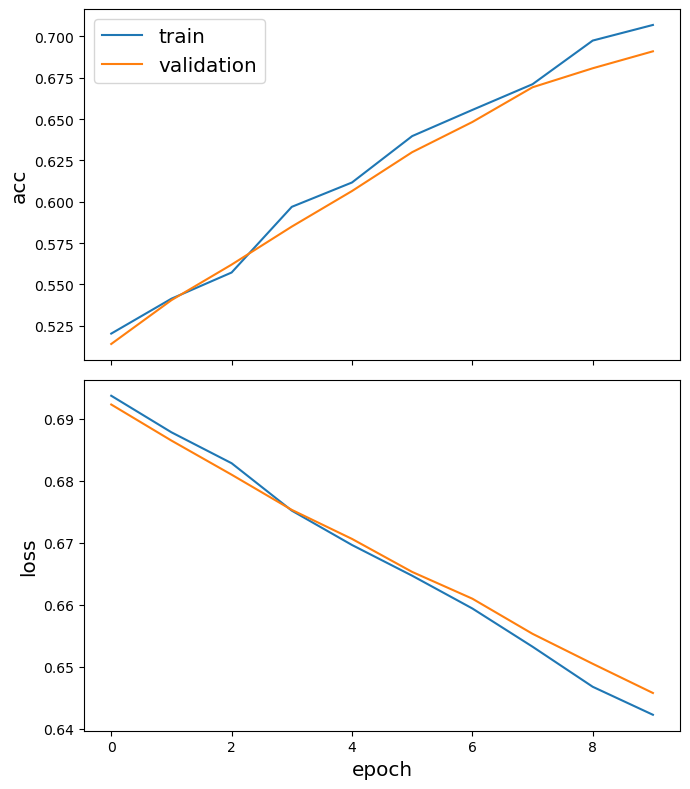

In [17]:
sg.utils.plot_history(history)

In [18]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

20/20 [==============================] - 14s 707ms/step - loss: 0.6458 - acc: 0.6877

Train Set Metrics of the trained model:
	loss: 0.6311
	acc: 0.7364

Test Set Metrics of the trained model:
	loss: 0.6458
	acc: 0.6877
